# Implementation of Adaptive Resonance Theory

## Setting the Vigilance parameter




In [1]:
#vigilance value in range from 0 to 1 (default 0.00001) 0.1
p = 0.7

## Importing Library Dependencies and MNIST dataset

In [2]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.datasets import mnist

## Data preparation and division

In [3]:
def grey_to_bin(data):
  dataset = []
  for d in data:
    array = []
    for i in d:
      row = []
      for j in i:
        if j != 0:
          row.append(1)
        else:
          row.append(0)
      array.append(row)
    dataset.append(array)
  return np.array(dataset)

def dimension_reduction(data):
  m, n, k = data.shape
  new_data = []
  for i in range(m):
    new_data.append(data[i].reshape(n*k,))
  return np.array(new_data)

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

train_X = grey_to_bin(train_X)
test_X = grey_to_bin(test_X)

train_X_low_dim = dimension_reduction(train_X)
test_X_low_dim = dimension_reduction(test_X)

11501568/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## Defining functions

In [4]:
def init_params(input_vectors):
    n, m = input_vectors.shape

    T = np.ones((1, m), dtype=float)
    B = np.empty((1, m), dtype=float)
    B.fill(1/(m + 1))

    default_T = np.ones((1, m), dtype=float)
    default_B = np.empty((1, m), dtype=float)
    default_B.fill(1/(m + 1))

    previous_T = np.zeros((1, m), dtype=float)
    previous_B = np.zeros((1, m), dtype=float)

    return T, B, default_T, default_B, previous_T, previous_B

def is_stable(previous_matrix, current_matrix):
  return np.array_equal(previous_matrix, current_matrix)


def calculate_y(input_vector, B):
  #m, n = B.shape
  y = []
  for i in B:
    tmp = np.sum(i * input_vector)
    y.append(tmp)
  
  y = np.array(y)
  return y

def max_val_index(array, exeption):
  max = 0
  index = 0
  for i in range(len(array)):
    if array[i] not in exeption:
      if array[i] > max:
        max = array[i]
        index = i
  return max, index

def compare_value(input_vector, T, index_of_T):
  numerator = np.sum(input_vector * T[index_of_T])
  denominator = np.sum(input_vector)
  return numerator / denominator

def vigil_cond(calculated_value, vigilance_value):
  if calculated_value > vigilance_value:
    return True
  return False

def condition_checker(vector, b, vig_value, T):
  y_array = calculate_y(vector, b)
  exeption = []
  vigilance_satisfied = False
  while y_array.shape[0] != len(exeption):
    value, index = max_val_index(y_array, exeption)
    if vigil_cond(compare_value(vector, T, index), vig_value):
      vigilance_satisfied = True
      break
    else:
      exeption.append(value)
  return index, value, y_array, vigilance_satisfied


def update_B(input_vector, T, index, B):
  numerator = T[index] * input_vector
  denominator = 0.5 + np.sum(numerator)
  value = numerator / denominator
  tmp = np.copy(B)
  tmp[index] = value
  return tmp

def update_T(input_vector, T, index, B):
  value = T[index] * input_vector
  tmp = np.copy(T)
  tmp[index] = value
  return tmp

def generate_new_B(input_vector, T, default_T, B, default_B):
  new_B = update_B(input_vector, default_T, 0, default_B)
  return np.vstack((B, new_B))

def generate_new_T(input_vector, T, default_T, B, default_B):
  new_T = update_T(input_vector, default_T, 0, default_B)
  return np.vstack((T, new_T))

## Execution

In [ ]:
T, B, default_T, default_B, previous_T, previous_B = init_params(train_X_low_dim[0:10000])

epoch_count = 0

while (not is_stable(previous_T, T)) and (not is_stable(previous_B, B)):
  epoch_count += 1
  iteration = 0

  previous_T = T.copy()
  previous_B = B.copy()

  for vector in train_X_low_dim[0:10000]:
    index, value, y_array, condition = condition_checker(vector, B, p, T)
    if condition:
      B = update_B(vector, T, index, B)
      T = update_T(vector, T, index, B)
    else:
      B = generate_new_B(vector, T, default_T, B, default_B)
      T = generate_new_T(vector, T, default_T, B, default_B)
    
    if iteration % 1000 == 0:
      print("iteration --> " + str(iteration))
    iteration += 1

  print('previous_T -> ' + str(previous_T.shape))
  print('previous_B -> ' + str(previous_B.shape))
  print('updated T  -> ' + str(T.shape))
  print('updated B  -> ' + str(B.shape))
print(epoch_count)

iteration --> 0
iteration --> 1000
iteration --> 2000


In [ ]:
from sklearn.metrics.cluster import contingency_matrix

b = B.copy()
x = train_y[0:10000].copy()
y = []
for vector in train_X_low_dim[0:10000]:
    y_array = calculate_y(vector, b)
    index = y_array.argmax()
    y.append(index)
y = np.array(y)

print(x.shape)
print(y.shape)
result = contingency_matrix(x, y)
print(result)

(10000,)
(10000,)
[[148   2  35  20   1 747   2  46]
 [ 39 298   1   0   0 285   0 504]
 [ 56  74   2   6  16 705   2 130]
 [ 29  14  36   4   5 874   0  70]
 [196 111  31  17   6  72   1 546]
 [109  18  27   1   2 428   0 278]
 [  5 160  32  22   1 493   6 295]
 [352 154  98 237  22 170   0  37]
 [ 21  11   2   0   0 755   0 155]
 [ 63  76  27  16   1 506   0 289]]


## CONT


In [ ]:
with open('B.txt', 'w') as f:
    for item in B:
        f.write("%s\n" % item)

In [ ]:
print(T.shape)

(8, 784)



# Testing

In [ ]:
#TESTING PURPOSE
v = []
v.append([1, 1, 0, 0, 0, 0, 1])
v.append([0, 0, 1, 1, 1, 1, 0])
v.append([1, 0, 1, 1, 1, 1, 0])
v.append([0, 0, 0, 1, 1, 1, 0])
v.append([1, 1, 0, 1, 1, 1, 0])
input_vectors = np.array(v)
p = 0.7

t = np.ones((1, 7), dtype=float)
b = np.empty((1, 7), dtype=float)
b.fill(1/(7 + 1))

default_t = np.copy(t)
default_b = np.copy(b)

print(v)
print(b)
print(t)

prev_T = np.zeros((1, 7), dtype=float)
prev_B = np.zeros((1, 7), dtype=float)

epochCount = 0
count = 0


print('STARTING......')



while (not is_stable(prev_T, t)) and (not is_stable(prev_B, b)):
  epochCount += 1

  prev_T = t.copy()
  prev_B = b.copy()

  for vector in input_vectors:
    print("vector:" + str(vector) + "")

    #y_array = calculate_y(vector, b)
    index, value, y_array, condition = condition_checker(vector, b, p, t)
    
    #print("value : ---> " + str(value) + " <---")
    #print("index : ---> " + str(index) + " <---")
    print("array :" + str(y_array) + "")
    print(compare_value(vector, t, index))

    if condition:
      b = update_B(vector, t, index, b)
      t = update_T(vector, t, index, b)
      print(b)
      print(t)
    else:
      b = generate_new_B(vector, t, default_t, b, default_b)
      t = generate_new_T(vector, t, default_t, b, default_b)
      print(b)
      print(t)
    print('\nCount ' + str(count))
    count += 1
  

[[1, 1, 0, 0, 0, 0, 1], [0, 0, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0]]
[[0.125 0.125 0.125 0.125 0.125 0.125 0.125]]
[[1. 1. 1. 1. 1. 1. 1.]]
STARTING......
vector:[1 1 0 0 0 0 1]
array :[0.375]
1.0
[[0.28571429 0.28571429 0.         0.         0.         0.
  0.28571429]]
[[1. 1. 0. 0. 0. 0. 1.]]

Count 0
vector:[0 0 1 1 1 1 0]
array :[0.]
0.0
[[0.28571429 0.28571429 0.         0.         0.         0.
  0.28571429]
 [0.         0.         0.22222222 0.22222222 0.22222222 0.22222222
  0.        ]]
[[1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0.]]

Count 1
vector:[1 0 1 1 1 1 0]
array :[0.28571429 0.88888889]
0.8
[[0.28571429 0.28571429 0.         0.         0.         0.
  0.28571429]
 [0.         0.         0.22222222 0.22222222 0.22222222 0.22222222
  0.        ]]
[[1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0.]]

Count 2
vector:[0 0 0 1 1 1 0]
array :[0.         0.66666667]
1.0
[[0.28571429 0.28571429 0.         0.         0.         0.
  

## Definition of additional functions

In [ ]:
def plot_image(dataset, index):
  plt.subplots(nrows=0, ncols=0)
  plt.figure(figsize=(10, 6))
  plt.imshow(dataset[index], cmap=plt.get_cmap('gray'))
  plt.show()

## Test Results

<Figure size 432x288 with 0 Axes>

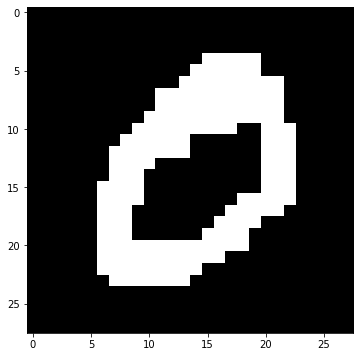

4


In [ ]:
plot_image(train_X, 1)
print(train_y[2])